In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score

In [37]:
import os
def read_dataset(folder_path):
    data_dict = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            data_dict[filename] = df.astype(float)
    return data_dict

ds = {}
dsLists = ["AICU","Automatoes","Digilog","IUACAAS","Reference","TheAutomators"]
for name in dsLists:
    folder_path = f"../{name}"
    data_dict = read_dataset(folder_path)
    ds[name] = data_dict

C:\Users\thanh\AppData\Local\Temp\ipykernel_20388\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\thanh\AppData\Local\Temp\ipykernel_20388\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\thanh\AppData\Local\Temp\ipykernel_20388\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\thanh\AppData\Local\Temp\ipykernel_20388\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31

In [57]:
class SensorPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=2):
        super(SensorPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout=0.2,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out                      # (batch*7, 1)

In [58]:
def load_and_scale_data(df, features):
    data = df[features].copy()
    data = data.interpolate(method='linear')
    data = data.fillna(method='bfill').fillna(method='ffill')  # đảm bảo không còn NaN
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    df = pd.DataFrame(data_scaled, columns=features)
    return df, scaler

# === STEP 2: Create LSTM dataset ===
def create_lstm_dataset(df, input_seq_len=288, predict_len=288):
    X, Y = [], []
    total_steps = len(df)
    for i in range(total_steps - input_seq_len - predict_len):
        x_seq = df.iloc[i:i + input_seq_len].values
        y_seq = df.iloc[i + input_seq_len : i + input_seq_len + predict_len].values
        X.append(x_seq)
        Y.append(y_seq[-1])  # chỉ lấy bước 288 để đơn giản
    return np.array(X), np.array(Y)

# === STEP 3: Reshape for LSTM ===
def reshape_for_lstm(X, Y):
    B, T, F = X.shape
    X = X.transpose(0, 2, 1).reshape(-1, T, 1)  # (B*F, T, 1)
    Y = Y.reshape(-1, F)                      # (B, F)
    Y = Y.reshape(-1, 1)                      # (B*F, 1)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

In [59]:
def train_model(model, train_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available(): 
        print(f"Training on {torch.cuda.get_device_name(0)}")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_targets = []

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            all_preds.append(pred.detach().cpu().numpy())
            all_targets.append(yb.detach().cpu().numpy())

        # Gộp lại để tính metrics
        y_true = np.vstack(all_targets)
        y_pred = np.vstack(all_preds)
        rmse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    return y_true, y_pred  # return for visualization


In [60]:
features = ["BlackScr", "PipeGrow", "PipeLow", "Tot_PAR", "VentLee", "Ventwind", "t_heat_sp"]
df = ds["Digilog"]["GreenhouseClimate.csv"][features]

# Load & scale
scaled_df, scaler = load_and_scale_data(df, features)

# Tạo dataset
X, Y = create_lstm_dataset(scaled_df, input_seq_len=48, predict_len=288)

# Reshape cho LSTM
x_tensor, y_tensor = reshape_for_lstm(X, Y)

# DataLoader
dataset = TensorDataset(x_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Khởi tạo và train model
model = SensorPredictor()
y_true, y_pred = train_model(model, train_loader, epochs=50)

C:\Users\thanh\AppData\Local\Temp\ipykernel_20388\3440510517.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')  # đảm bảo không còn NaN


Training on NVIDIA GeForce RTX 3060 Laptop GPU
Epoch 1/50, Loss: 0.0184, RMSE: 0.0184, R²: 0.8458
Epoch 2/50, Loss: 0.0173, RMSE: 0.0173, R²: 0.8555
Epoch 3/50, Loss: 0.0171, RMSE: 0.0171, R²: 0.8574
Epoch 4/50, Loss: 0.0161, RMSE: 0.0161, R²: 0.8651
Epoch 5/50, Loss: 0.0155, RMSE: 0.0155, R²: 0.8701
Epoch 6/50, Loss: 0.0154, RMSE: 0.0154, R²: 0.8714
Epoch 7/50, Loss: 0.0152, RMSE: 0.0152, R²: 0.8726
Epoch 8/50, Loss: 0.0150, RMSE: 0.0150, R²: 0.8745
Epoch 9/50, Loss: 0.0148, RMSE: 0.0148, R²: 0.8759
Epoch 10/50, Loss: 0.0146, RMSE: 0.0146, R²: 0.8779
Epoch 11/50, Loss: 0.0143, RMSE: 0.0143, R²: 0.8802
Epoch 12/50, Loss: 0.0142, RMSE: 0.0142, R²: 0.8813
Epoch 13/50, Loss: 0.0139, RMSE: 0.0139, R²: 0.8841
Epoch 14/50, Loss: 0.0136, RMSE: 0.0136, R²: 0.8862
Epoch 15/50, Loss: 0.0133, RMSE: 0.0133, R²: 0.8885
Epoch 16/50, Loss: 0.0130, RMSE: 0.0130, R²: 0.8916
Epoch 17/50, Loss: 0.0128, RMSE: 0.0128, R²: 0.8934
Epoch 18/50, Loss: 0.0124, RMSE: 0.0124, R²: 0.8959
Epoch 19/50, Loss: 0.0122,

In [61]:
num_features = 7
y_true_reshaped = y_true.reshape(-1, num_features)
y_pred_reshaped = y_pred.reshape(-1, num_features)


In [62]:
import matplotlib.pyplot as plt

def plot_feature_predictions(y_true_all, y_pred_all, feature_names, num_samples=100):
    """
    Plot predictions vs actuals for each feature.
    """
    for i, feature in enumerate(feature_names):
        plt.figure(figsize=(10, 4))
        plt.plot(y_true_all[:num_samples, i], label="Actual", linewidth=2)
        plt.plot(y_pred_all[:num_samples, i], label="Predicted", linestyle="--")
        plt.title(f"Predicted vs Actual: {feature}")
        plt.xlabel("Sample Index")
        plt.ylabel("Normalized Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


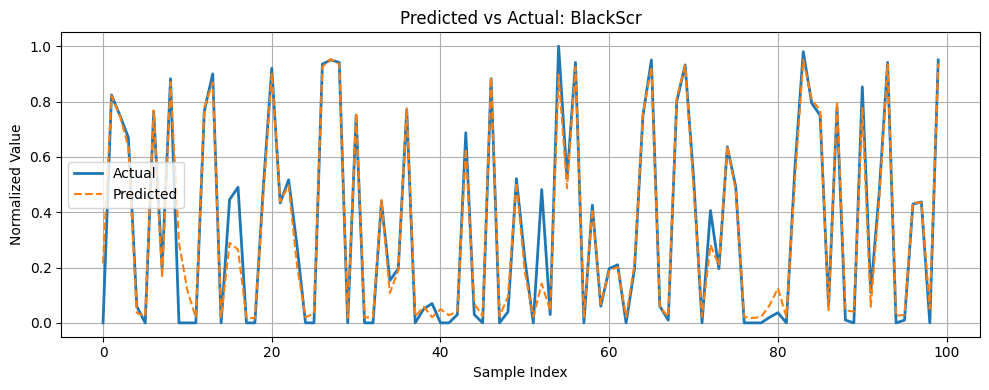

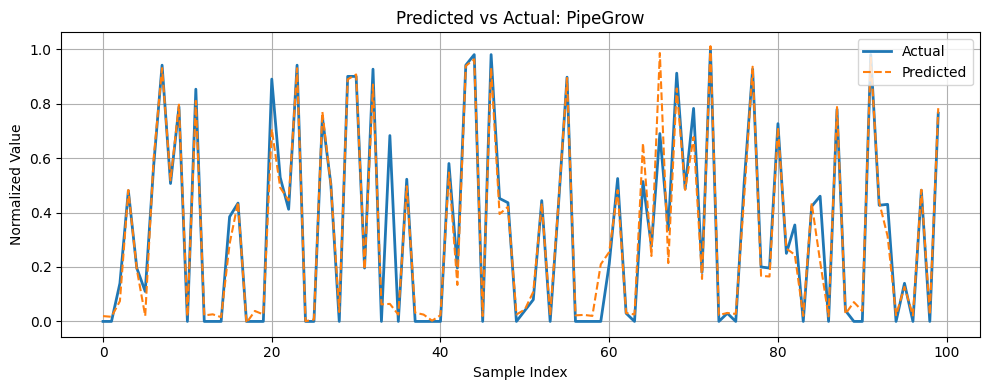

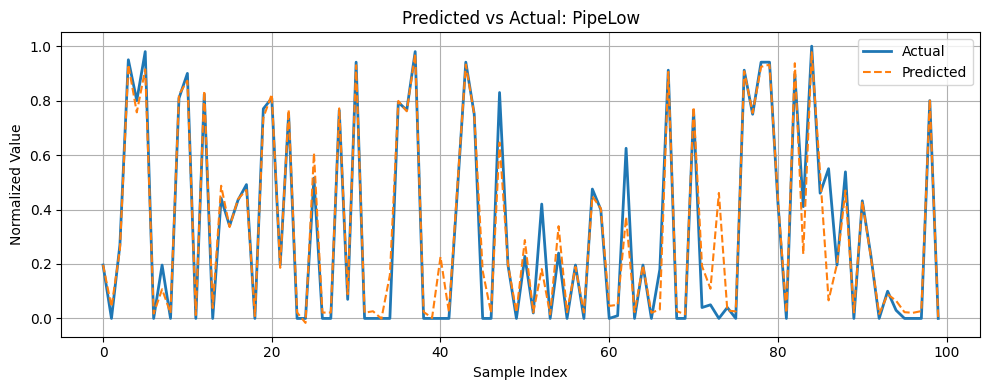

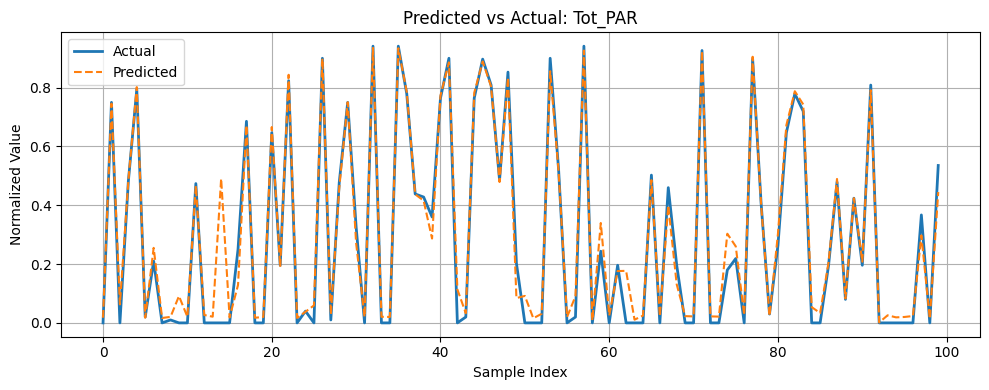

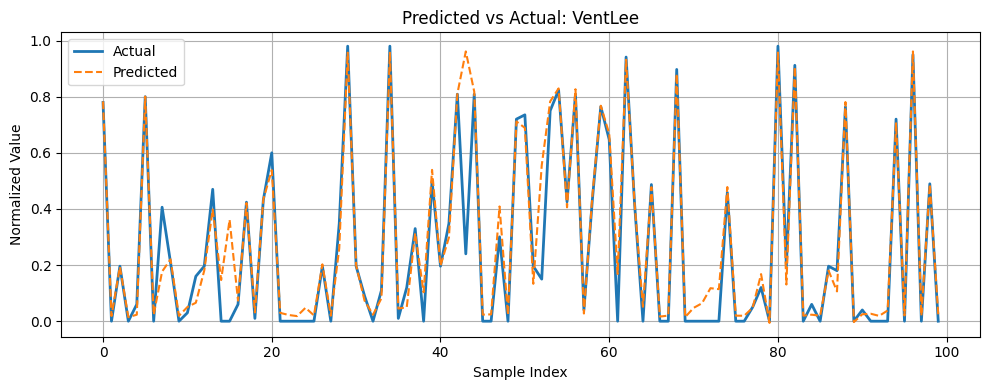

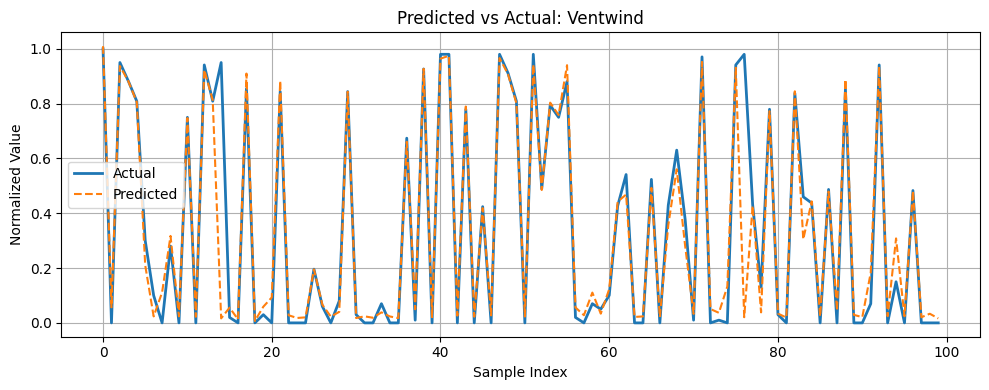

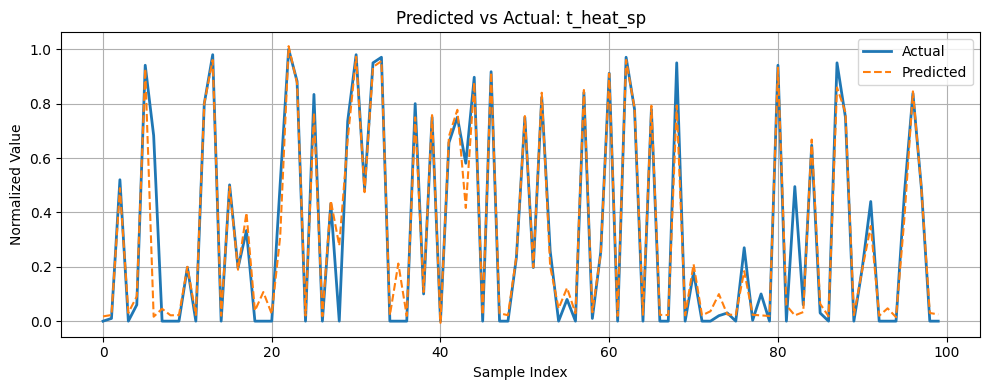

In [63]:
features = ["BlackScr", "PipeGrow", "PipeLow", "Tot_PAR", "VentLee", "Ventwind", "t_heat_sp"]
plot_feature_predictions(y_true_reshaped, y_pred_reshaped, features)


In [65]:
torch.save(model.state_dict(), "sensor_predictor.pth")

### GRUD


In [68]:


class SensorGRUD(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=2):
        super(SensorGRUD, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU-D cell
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

        # Decay parameters
        self.gamma_x = nn.Parameter(torch.ones(input_size))
        self.gamma_h = nn.Parameter(torch.ones(hidden_size))

    def forward(self, x, mask=None, delta=None):
        # x: (batch, seq_len, input_size)
        # mask: (batch, seq_len, input_size) - 1 if observed, 0 if missing
        # delta: (batch, seq_len, input_size) - time since last observation

        if mask is not None and delta is not None:
            # Apply decay to missing values
            gamma_x = torch.exp(-torch.relu(self.gamma_x) * delta)
            x = mask * x + (1 - mask) * gamma_x * x

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


In [69]:

# Khởi tạo và train model
model = SensorGRUD()
y_true, y_pred = train_model(model, train_loader, epochs=50)

Training on NVIDIA GeForce RTX 3060 Laptop GPU
Epoch 1/50, Loss: 0.0178, RMSE: 0.0178, R²: 0.8514
Epoch 2/50, Loss: 0.0158, RMSE: 0.0158, R²: 0.8682
Epoch 3/50, Loss: 0.0152, RMSE: 0.0152, R²: 0.8726
Epoch 4/50, Loss: 0.0149, RMSE: 0.0149, R²: 0.8751
Epoch 5/50, Loss: 0.0145, RMSE: 0.0145, R²: 0.8790
Epoch 6/50, Loss: 0.0138, RMSE: 0.0138, R²: 0.8842
Epoch 7/50, Loss: 0.0133, RMSE: 0.0133, R²: 0.8891
Epoch 8/50, Loss: 0.0127, RMSE: 0.0127, R²: 0.8940
Epoch 9/50, Loss: 0.0122, RMSE: 0.0122, R²: 0.8977
Epoch 10/50, Loss: 0.0118, RMSE: 0.0118, R²: 0.9011
Epoch 11/50, Loss: 0.0115, RMSE: 0.0115, R²: 0.9039
Epoch 12/50, Loss: 0.0111, RMSE: 0.0111, R²: 0.9074
Epoch 13/50, Loss: 0.0108, RMSE: 0.0108, R²: 0.9097
Epoch 14/50, Loss: 0.0105, RMSE: 0.0105, R²: 0.9122
Epoch 15/50, Loss: 0.0104, RMSE: 0.0104, R²: 0.9134
Epoch 16/50, Loss: 0.0101, RMSE: 0.0101, R²: 0.9156
Epoch 17/50, Loss: 0.0099, RMSE: 0.0099, R²: 0.9173
Epoch 18/50, Loss: 0.0098, RMSE: 0.0098, R²: 0.9181
Epoch 19/50, Loss: 0.0097,

In [70]:
torch.save(model.state_dict(), "sensor_predictor_grud.pth")